# VAE on HSC images

In [1]:
import matplotlib.pyplot as plt
import torch
from datasets import load_from_disk

from galgenai import VAE, get_device, get_device_name


device = get_device()
print(f"Using device: {get_device_name()}")

Using device: cuda


## Load and inspect data

In [2]:
dataset = load_from_disk("/data/a/cpac/fkeruzore/hsc_mmu/")
dataset = dataset.select_columns(["image"]).with_format("torch")

n_gals = len(dataset)
n_bands, n_x, n_y = dataset[0]["image"]["flux"].shape
assert n_x == n_y
print(f"Images dimension: {n_bands}*{n_x}*{n_y} ({n_gals} galaxies)")
bands = dataset[0]["image"]["band"]
assert len(bands) == n_bands

# dataset.set_transform(lambda data: {"flux": data["image"]["flux"]})
# dataset = dataset.map(lambda x: {"flux": x["image"]["flux"]}, remove_columns=["image"])

class FluxDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]["image"]["flux"]

dataset = FluxDataset(dataset)

Images dimension: 5*160*160 (86614 galaxies)


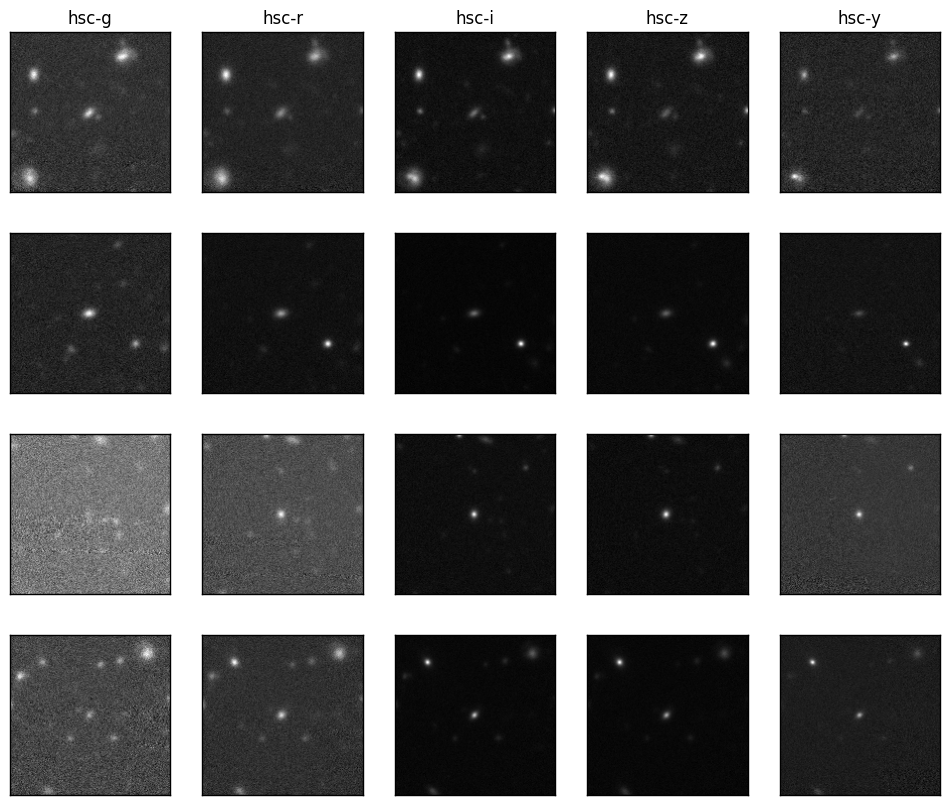

In [3]:
_n_plot = 4
fig, axs = plt.subplots(_n_plot, n_bands, figsize=(12, 10))

for i in range(_n_plot):
    axs_row = axs[i]
    ds = dataset[i]
    for im, band, ax in zip(ds, bands, axs_row, strict=True):
        ax.imshow(im, origin="lower", cmap="gray")
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        if i == 0:
            ax.set_title(band)

## Define model

In [4]:
model = VAE(in_channels=n_bands, latent_dim=32, input_size=n_x).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

Model parameters: 66,989,461


In [5]:
x = torch.randn(4, n_bands, n_x, n_y).to(device)  # batch
print(f"Input shape: {x.shape}")

reconstruction, mu, logvar = model(x)
print(f"Reconstruction shape: {reconstruction.shape}")
print(f"Latent mean shape: {mu.shape}")
print(f"Latent log variance shape: {logvar.shape}")

Input shape: torch.Size([4, 5, 160, 160])
Reconstruction shape: torch.Size([4, 5, 160, 160])
Latent mean shape: torch.Size([4, 32])
Latent log variance shape: torch.Size([4, 32])


## Check pre-training outputs

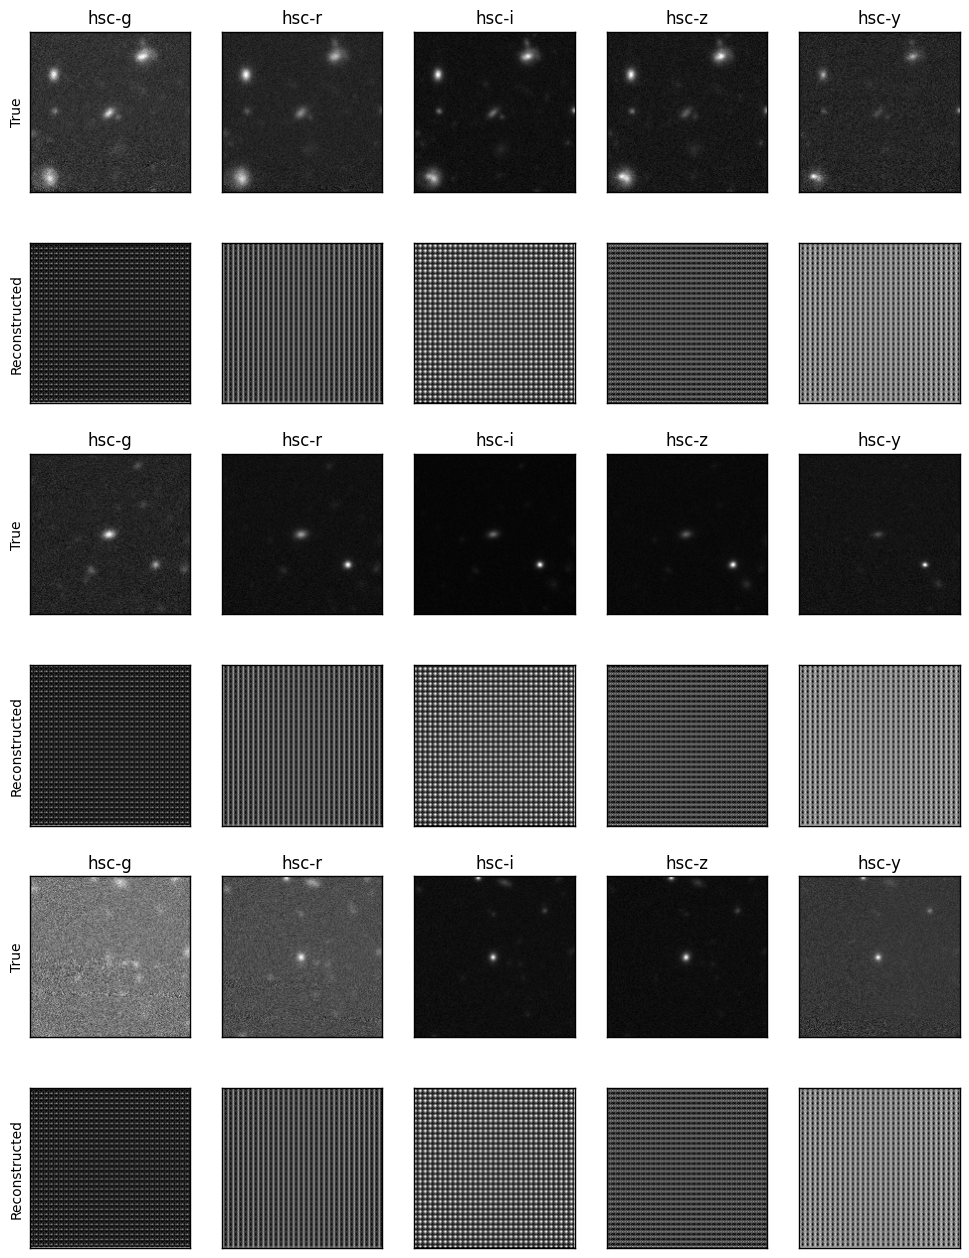

In [8]:
model.eval()
_n_plot = 3

imgs = torch.stack([dataset[i] for i in range(4)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        axs_row_true[j].imshow(imgs[i, j].cpu(), origin="lower", cmap="gray")
        axs_row_reco[j].imshow(recs[i, j].cpu(), origin="lower", cmap="gray")

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)

## Train

In [10]:
from torch.utils.data import DataLoader, random_split
from galgenai.training import train

BATCH_SIZE = 128
NUM_WORKERS = 4

dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(
    dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True,
)
test_loader = DataLoader(
    dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False,
)

train(
    model=model,
    train_loader=train_loader,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    device=device,
    num_epochs=4,
    reconstruction_loss_fn="mse",
    beta=1.0,
)

Training on device: cuda
Number of epochs: 4
Reconstruction loss: mse
Beta: 1.0
------------------------------------------------------------

Epoch 1/4 (lr: 0.001000)


Training:   0%|          | 0/542 [00:00<?, ?it/s]

Training: 100%|██████████| 542/542 [05:55<00:00,  1.52it/s, loss=28217.9336, recon=27899.3984, kl=318.5335]            


Epoch 1 Summary - Total Loss: 30683626.2636, Recon Loss: 131706.0547, KL Loss: 30551920.4667

Epoch 2/4 (lr: 0.001000)


Training: 100%|██████████| 542/542 [05:24<00:00,  1.67it/s, loss=229394.1719, recon=229040.6875, kl=353.4787]  


Epoch 2 Summary - Total Loss: 130379.8321, Recon Loss: 129955.4986, KL Loss: 424.3334

Epoch 3/4 (lr: 0.001000)


Training: 100%|██████████| 542/542 [06:16<00:00,  1.44it/s, loss=530825.1250, recon=530454.2500, kl=370.8500]    


Epoch 3 Summary - Total Loss: 131909.1242, Recon Loss: 130516.8709, KL Loss: 1392.2533

Epoch 4/4 (lr: 0.001000)


Training: 100%|██████████| 542/542 [05:08<00:00,  1.76it/s, loss=90406.6953, recon=89850.2266, kl=556.4634]     

Epoch 4 Summary - Total Loss: 138794.7640, Recon Loss: 130109.1217, KL Loss: 8685.6422


## Check post-training outputs

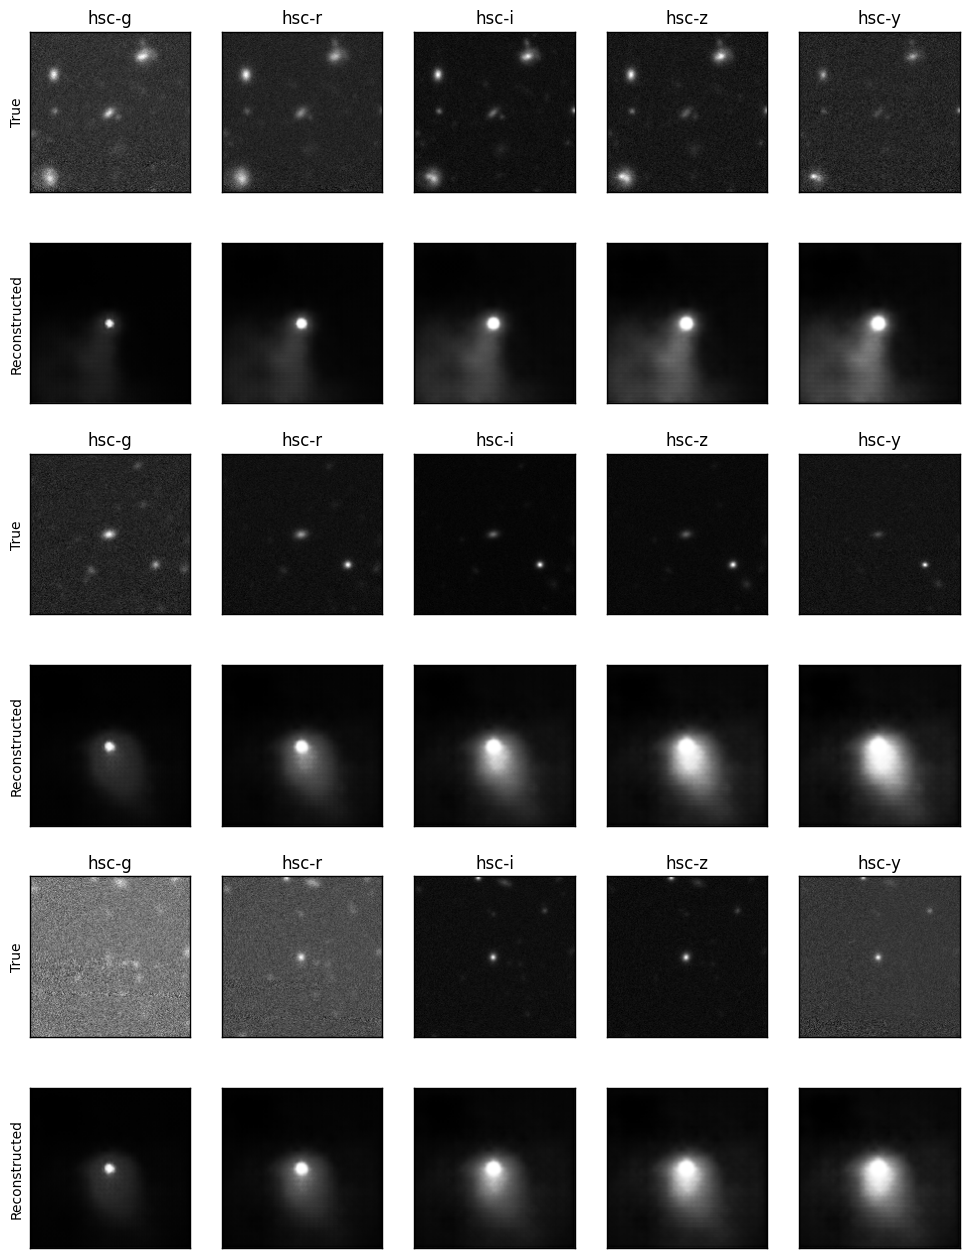

In [11]:
model.eval()
_n_plot = 3

imgs = torch.stack([dataset[i] for i in range(4)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        axs_row_true[j].imshow(imgs[i, j].cpu(), origin="lower", cmap="gray")
        axs_row_reco[j].imshow(recs[i, j].cpu(), origin="lower", cmap="gray")

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)
